필요한 라이브러리 import

In [1]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 17.5 MB/s eta 0:00:00


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re
from konlpy.tag import Okt
import matplotlib.pyplot as plt
import pandas as pd

공지사항 데이터 df에 저장

In [34]:
# CSV 파일 읽기
csv_filename = '공지사항.csv'
df = pd.read_csv(csv_filename)

# 'id' 열을 인덱스로 지정
df = df.set_index('id')

df

,Cid,title,hits,time
id,,,,
1,1,(예비군연대) 2023년 6월 각 군 현역병 모집계획 안내,조회 116,2023.05.26.
2,1,2023 세계스카우트잼버리 영외과정활동 「사찰문화체험」 통역 자원봉사자 모집,조회 99,2023.05.26.
3,1,「대학생 테마별 톡톡 멘토링」 참여 동아리 추가모집,조회 180,2023.05.25.
4,1,「2023년 국가간 청소년교류」 및 「글로벌 청소년 서밋」청소년 참가자 모집,조회 174,2023.05.25.
5,1,2023-1 실험실습 교과목 만족도 조사 안내 (드림패스 마일리지 지급),조회 125,2023.05.25.
...,...,...,...,...
10096,10,2019년 1학기 학석 공통 과목 개설목록 안내,675,2019-01-24
10097,10,대학원 강좌 수강신청 안내,487,2019-01-23
10098,10,2019학년도 봄 학위수여식 일정 공지,421,2019-01-15


df에서 공지 제목을 추출

In [36]:
# 제목 추출 및 저장
notice_names = df['title'].tolist()
for notice in notice_names:
  print(notice)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2021학년도 1학기 재학생 전액장학생 등록금 납부 안내
2021학년도 1학기 재학생 등록금 신용카드 납부 안내
2021학년도 학점등록생 등록금 납부 안내
2021학년도 1학기 재학생 등록금 분할납부 안내
2021학년도 1학기 재학생 등록금 납부 안내
2021학년도 1학기 『창업대체학점 인정제(창업실습 및 창업현장실습)』 운영 안내
2021년 봄 졸업대상자 졸업심사 판정 결과 확인 및 uDRIMS 영문성명 입력 안내
2020학년도 겨울학기 현장실습 과제 제출안내
2021학년도 신입생 영어레벨테스트 안내
2021년 봄 졸업대상자 교원자격 무시험검정 신청 안내
2021-1학기 학부 수강신청 FAQ
2021학년도 1학기 학석사연계과정 모집 안내(2차)
2021-1학기 학부 수강신청 안내
2021 근로장학사 서류평가 결과 및 면접일정 안내
(필독)2021학년도 1학기 사이버강좌(일반교양) 시험일정
2021학년도 1학기 교양교과목 수강신청관련 FAQ
2021학년도 공통교양/학문기초/일반교양 이수학점 변경 안내
2021학년도 공통교양(영어) 이수학점 변경 안내
[LINC+] 창조경제혁신센터와 함께하는 2021-1학기 기업사회맞춤형프로젝트1 참여학생모집
2021-1학기 희망강의 신청 안내
2021학년도 1학기 수강신청일정 변경 안내
2021-1학기 학석사연계과정,학석박사통합연계과정 신청자 심사결과 안내
2021년 봄 졸업예정자 대상 선택적 수료 제도 시행 안내
2021학년도 1학기 학부생 휴학 신청 안내
2021학년도 1학기 복학 신청(2차) 안내
2021-1학기 현장실습 참가학생 모집
2020년도 교육비납입증명서 발급 안내
근로장학사 사생 모집
2021학년도 1학기 현장실습 교과목 운영 안내
1월 6일 모의토익 고사장 및 성적 확인 방법 안내
2021년도 신입생 입학전 사전교육 프로그램 접수 안내
2021년 봄 졸업 관련 외국어 패스제 한시적 면제 시행 안내
1월 4일 모의토익 고사장 및 성적 확인 방법 안

공지 제목에서 특수문자, 숫자, 불용어를 제거해주는 전처리 함수 정의

In [16]:
# 전처리 함수 정의
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)

    # 숫자 정보 제거
    text = re.sub(r'\d+', '', text)

    # 형태소 분석
    tagger = Okt()
    words = tagger.morphs(text)

    # 불용어 제거
    stop_words = [ '필독', '학기', '학년', '도', '년', '제', '회', '월', '학부', '일', '차', '년도', '안내']  # 불용어 리스트
    words = [word for word in words if word not in stop_words]

    # 분석된 형태소들을 공백으로 결합하여 문장으로 반환
    text = ' '.join(words)

    return text

전처리 된 내용을 확인

In [17]:
# 전처리된 공지이름 추출
preprocessed_notice_names = [preprocess_text(notice_name) for notice_name in notice_names]

print("전처리 공지 제목")

for notice in preprocessed_notice_names:
  print(notice)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
재학생 전액 장학생 등록금 납부
재학생 등록금 신용카드 납부
학점 등록 생 등록금 납부
재학생 등록금 분할 납부
재학생 등록금 납부
창업 대체 학점 인정 창업 실습 및 창업 현장 실습 운영
봄 졸업 대상자 졸업 심사 판정 결과 확인 및 uDRIMS 영문 성명 입력
겨울 현장 실습 과제 제출
신입생 영어 레벨 테스트
봄 졸업 대상자 교원자격 무 시험 검정 신청
수강신청 FAQ
학 석 사연 계 과정 모집 안 내
수강신청
근로 장학사 서류 평가 결과 및 면접 일정
사이버 강좌 일반 교양 시험 일정
교양 교과목 수강신청 관련 FAQ
공 통교 양 학문 기초 반 교양 이수 학점 변경
공통 교양 영어 이수 학점 변경
LINC 창조경제 혁신 센터 와 함께 하는 기업 사회 맞춤 형 프로젝트 참여 학생 모집
희망 강의 신청
수강신청 일정 변경
학 석 사연 계 과 정학 석 박사 통합 연 계 과정 신청 자 심사 결과
봄 졸업 예정자 대상 선택 적 수료 제도 시행
생 휴학 신청
복학 신 청차
현장 실습 참가 학생 모집
교육비 납 입증 명 서 발급
근로 장학사 사생 모집
현장 실습 교과목 운영
모의 토익 고 사장 및 성적 확인 방법
신입생 입학 전 사전 교육 프로그램 접수
봄 졸업 관련 외국어 패스 한시 적 면제 시행
모의 토익 고 사장 및 성적 확인 방법
수업 운영 계획
복학 신 청차
모의 토익 고 사장 및 성적 확인 방법
모의 토익 고 사장 및 성적 확인 방법
모의 토익 고 사장 및 성적 확인 방법
겨울 계절 최종 개설 확정 강좌
학사 석 박사 통합 연 계 과정 모집
학 석 사연 계 과정 모집
학 석 사연 계 과정 설명 자료 공유
겨울 현장 실습 사전 직무 교육 OT
모의 토익 고 사장 및 성적 확인 방법
겨울 계절 최종 개설 폐설 강좌 공지 및 폐강 대체 수강신청 등록
학점 포기 취득 교과목 포기 안 내
학 석 사연 계 과정 설명
EAS 영어 발표 경진 대회 수상자 및 시상식
EAS 영어 글쓰기 경진 대회 수상자 및

전처리된 것을 TF-IDF로 벡터화 진행

In [18]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

벡터화 한것을 k-means++로 클러스터링 진행
이떄, Elbow method로 최적의 k값 탐색

여기까지 잘됨


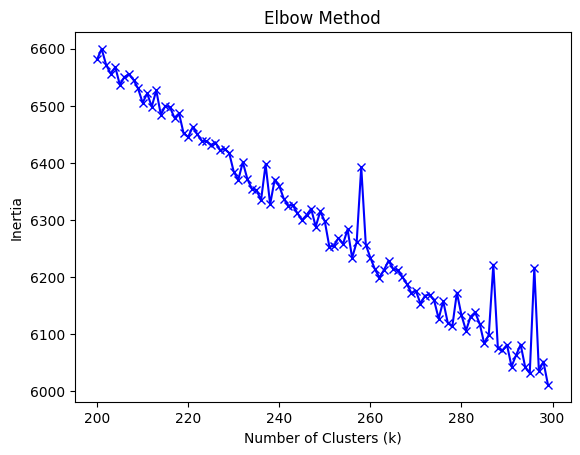

In [23]:
# Elbow Method를 사용하여 적절한 클러스터 개수 k 결정
inertias = []
k_values = range(200, 300)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Elbow Method를 시각화하여 적절한 k 결정
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

적절한 k값을 입력하여 k-means++ 진행
(임시로 k=500)

In [25]:
# 사용자로부터 적절한 클러스터 개수 k 입력
k = int(input("Enter the number of clusters (k): "))

# K-means 클러스터링
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
kmeans.fit(X)

Enter the number of clusters (k): 500


KMeans(n_clusters=500, n_init=10, random_state=42)

클러스터링 결과를 통해 그룹화

In [ ]:
# 각 공지사항에 대한 클러스터 할당
labels = kmeans.labels_

# 클러스터별로 공지사항 그룹화
clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(notice_names[i])

클러스터링 결과를 데이터 프레임에 추가

In [ ]:
# 클러스터 번호를 DataFrame에 추가
df['cluster'] = labels

# 클러스터 번호가 추가된 DataFrame 출력
df

,Cid,title,hits,time,cluster
id,,,,,
1,1,(예비군연대) 2023년 6월 각 군 현역병 모집계획 안내,조회 116,2023.05.26.,43
2,1,2023 세계스카우트잼버리 영외과정활동 「사찰문화체험」 통역 자원봉사자 모집,조회 99,2023.05.26.,25
3,1,「대학생 테마별 톡톡 멘토링」 참여 동아리 추가모집,조회 180,2023.05.25.,285
4,1,「2023년 국가간 청소년교류」 및 「글로벌 청소년 서밋」청소년 참가자 모집,조회 174,2023.05.25.,354
5,1,2023-1 실험실습 교과목 만족도 조사 안내 (드림패스 마일리지 지급),조회 125,2023.05.25.,140
...,...,...,...,...,...
10096,10,2019년 1학기 학석 공통 과목 개설목록 안내,675,2019-01-24,25
10097,10,대학원 강좌 수강신청 안내,487,2019-01-23,307
10098,10,2019학년도 봄 학위수여식 일정 공지,421,2019-01-15,214


그룹별로 이름 부여

In [ ]:
# 사용자가 직접 라벨을 지정
cluster_labels = {}
for label, notices in clusters.items():
    print(f"Cluster {label}:")
    for i, notice in enumerate(notices):
        print(f"{i+1}: {notice}")
    user_label = input("Enter the label for this group: ")
    cluster_labels[label] = user_label
    print()

# 각 공지사항에 라벨링 적용
notice_labels = {}
for i, label in enumerate(labels):
    notice_labels[notice_names[i]] = cluster_labels[label]

# 공지사항에 대한 라벨링 결과 출력
for notice, label in notice_labels.items():
    print(f"{notice}: {label}")

Cluster 43:
1: (예비군연대) 2023년 6월 각 군 현역병  모집계획 안내
2: (예비군연대) 2023년 5월 각 군 현역병  모집계획 안내
3: (예비군연대) 2023년 4월 각 군 현역병  모집계획 안내
4: (예비군연대) 2022년 9월 각 군 모집계획 안내
5: (예비군연대) 2022년 8월 각 군 모집계획 안내
6: (예비군연대) 2022년 7월 각 군 모집계획 안내
7: (예비군연대) 2022년 6월 각 군  모집계획 안내
8: (예비군연대) 2022년 3월 각 군 모집계획 안내
9: (예비군연대) 2022년 2월 각 군 모집계획 안내
10: (예비군연대) 재병역판정검사 일자 / 장소 본인선택 안내
11: (예비군연대) 2022년 병역판정검사 일자/장소 본인선택 안내
12: (예비군연대) 2022년 1월 각 군 모집계획 안내
13: (예비군연대) 2021년 12월 각 군 모집계획 안내
14: (예비군연대)  2021년 11월 각 군 모집계획 안내
15: (예비군연대) 2021년 10월 각 군 모집계획 안내
16: (예비군연대) 2021년 후기 자연계 대학원 전문연구요원 편입대상자 선발 공고 안내
17: (예비군연대) 2021년 9월 각 군 모집계획 안내
18: (예비군연대) 2022년 현역병 입영일자 본인선택원 접수일정 안내
19: (예비군연대) 2021년 7월 각 군 모집계획 안내
20: (예비군연대) 2021년 6월 각 군 모집계획 안내
21: (예비군연대)  2021년 5월 각 군 모집계획 안내
22: (예비군연대) 2021년도 전기 자연계 대학원 전문연구요원 편입대상자 선발 공고
23: (예비군연대) 2021년 4월 각 군 모집계획 안내
24: (예비군연대) 재병역판정검사 일자 / 장소 본인선택 안내
25: (예비군연대) 2021년 3월 각 군 모집계획 안내
Enter the label for this group: 예비군

Cluster 25:
1: 2023 세계스카우트잼버리 영외과정활동 「사찰문화체험」 통역 자원봉사자 모집
2:

KeyboardInterrupt: ignored

레이블이 부여된 공지사항 데이터를 가지고 csv파일 생성